In [56]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from scipy import interp
from sklearn import metrics, model_selection, grid_search
from astropy.table import Table
from metric_tools import *
from sklearn.externals import joblib

%matplotlib inline
sns.set(style="white", color_codes=True, context="poster")

mainpath = '/Users/jorgetil/Astro/HITS'
paper_fig_path = '/Users/jorgetil/Astro/HITS/Publications/Paper1/figures'

In [2]:
# load feature table into DF
table_file = '%s/tables/Blind15A_label_sample_new_PS.csv'\
              %(mainpath)
label_samp = pd.read_csv(table_file)
label_samp = label_samp.set_index('internalID')
print label_samp.shape

(2918, 75)


In [3]:
label_samp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2918 entries, Blind15A_01_N2_0998_2555 to Blind15A_50_N26_0050_2181
Data columns (total 75 columns):
ID                                 2918 non-null object
X                                  2918 non-null float64
Y                                  2918 non-null float64
raMedian                           2918 non-null float64
decMedian                          2918 non-null float64
spCl                               2595 non-null object
subClass                           1937 non-null object
Var_Type                           2918 non-null object
Var_subType                        263 non-null object
Amplitude                          2918 non-null float64
AndersonDarling                    2918 non-null float64
Autocor_length                     2918 non-null float64
Beyond1Std                         2918 non-null float64
CAR_mean                           2918 non-null float64
CAR_sigma                          2918 non-null float64
CAR_t

In [4]:
label_samp.head()

,ID,X,Y,raMedian,decMedian,spCl,subClass,Var_Type,Var_subType,Amplitude,...,Rcs,Skew,SlottedA_length,SmallKurtosis,Std,StetsonK,StetsonK_AC,g-i,g-r,r-i
internalID,,,,,,,,,,,,,,,,,,,,,
Blind15A_01_N2_0998_2555,HiTS091109-062237,998.957986,2555.433899,137.789887,-6.377161,NaN,NaN,RRLYR,AB,0.417481,...,0.200454,-0.807852,0.068778,-0.572473,0.275450,0.872417,0.799960,NaN,0.282769,NaN
Blind15A_01_N10_0255_0627,HiTS091228-062915,255.237107,627.992602,138.117172,-6.487559,NaN,NaN,EB,NaN,0.197396,...,0.156565,0.873591,0.060842,-0.124641,0.125667,0.742706,0.822326,NaN,0.291256,NaN
Blind15A_01_S3_0228_4039,HiTS091250-060924,228.923089,4039.118082,138.212302,-6.156819,NaN,NaN,EB,EA,1.259653,...,0.319373,2.104565,0.002645,3.965168,0.788831,0.607456,0.772652,NaN,0.484820,NaN
Blind15A_01_S6_0185_3231,HiTS091621-060913,185.866383,3231.985876,139.091233,-6.153690,NaN,NaN,EB,EW,0.188246,...,0.167320,0.143953,0.002645,-1.472723,0.136580,0.921360,0.778206,NaN,0.288442,NaN
Blind15A_01_S23_0518_0171,HiTS091412-054101,518.571146,171.240885,138.553390,-5.683874,NaN,NaN,RRLYR,NaN,0.055971,...,0.240294,-0.156972,0.203688,-1.417696,0.037549,0.918438,0.720318,NaN,1.360471,NaN


In [58]:
# columns with features
print label_samp.shape
feat = label_samp.columns.values
FATS_feats = feat[9:-3]
#FATS_feats = FATS_feats[FATS_feats!='Mean']
FATS_feats = np.append(FATS_feats, 'g-r')
FATS_feats = np.append(FATS_feats, 'g-i')
FATS_feats = np.append(FATS_feats, 'r-i')
print FATS_feats
label_samp.dropna(subset=FATS_feats, inplace=True)

(2330, 75)
['Amplitude' 'AndersonDarling' 'Autocor_length' 'Beyond1Std' 'CAR_mean'
 'CAR_sigma' 'CAR_tau' 'Con' 'Eta_e' 'FluxPercentileRatioMid20'
 'FluxPercentileRatioMid35' 'FluxPercentileRatioMid50'
 'FluxPercentileRatioMid65' 'FluxPercentileRatioMid80'
 'Freq1_harmonics_amplitude_0' 'Freq1_harmonics_amplitude_1'
 'Freq1_harmonics_amplitude_2' 'Freq1_harmonics_amplitude_3'
 'Freq1_harmonics_rel_phase_0' 'Freq1_harmonics_rel_phase_1'
 'Freq1_harmonics_rel_phase_2' 'Freq1_harmonics_rel_phase_3'
 'Freq2_harmonics_amplitude_0' 'Freq2_harmonics_amplitude_1'
 'Freq2_harmonics_amplitude_2' 'Freq2_harmonics_amplitude_3'
 'Freq2_harmonics_rel_phase_0' 'Freq2_harmonics_rel_phase_1'
 'Freq2_harmonics_rel_phase_2' 'Freq2_harmonics_rel_phase_3'
 'Freq3_harmonics_amplitude_0' 'Freq3_harmonics_amplitude_1'
 'Freq3_harmonics_amplitude_2' 'Freq3_harmonics_amplitude_3'
 'Freq3_harmonics_rel_phase_0' 'Freq3_harmonics_rel_phase_1'
 'Freq3_harmonics_rel_phase_2' 'Freq3_harmonics_rel_phase_3' 'Gskew'
 'L

In [59]:
label_samp = label_samp.query('(Var_Type == "RRLYR" or\
                                               Var_Type == "EB" or\
                                               Var_Type == "ROTVAR" or\
                                               Var_Type == "DSCT" or\
                                               Var_Type == "ZZ" or\
                                               Var_Type == "LPV") and\
                                               Period_fit < .5 or\
                                              (Var_Type != "RRLYR" and\
                                               Var_Type != "EB" and\
                                               Var_Type != "ROTVAR" and\
                                               Var_Type != "DSCT" and\
                                               Var_Type != "ZZ" and\
                                               Var_Type != "LPV")')

(2285, 75)
QSO       1850
RRLYR      141
NV         136
EB          86
CV          50
SNe          8
ROTVAR       7
MISC         4
LPV          2
DSCT         1
Name: Var_Type, dtype: int64


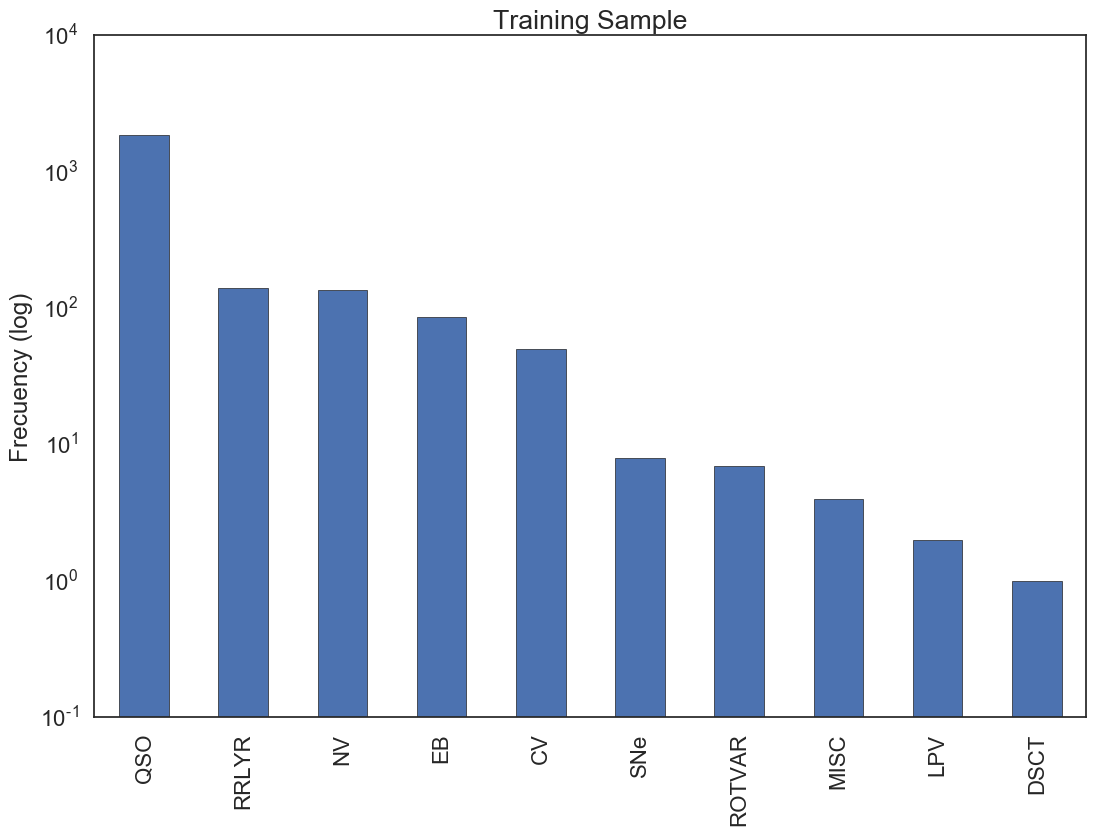

In [60]:
print label_samp.shape
print label_samp.Var_Type.value_counts()
label_samp.Var_Type.value_counts().plot(kind="bar")
plt.ylabel('Frecuency (log)')
plt.yscale('log')
plt.title('Training Sample')
plt.ylim(0.1,10000)
plt.show()

#### train test split using sklearn, stratify version

In [61]:
label_samp = label_samp[label_samp.Var_Type != 'DSCT']
label_samp = label_samp[label_samp.Var_Type != 'ZZ']
label_samp = label_samp[label_samp.Var_Type != 'LPV']

In [62]:
#table_15 = table_15.query('-2 < Color < 2 and 18 < Mean < 22 ')
train_sample, test_sample = model_selection.train_test_split(label_samp, 
                                                              test_size=0.4, random_state=15,
                                                             stratify=label_samp['Var_Type'])
print 'Shape of train set:', train_sample.shape
print 'Shape of test set:', test_sample.shape

Shape of train set: (1369, 75)
Shape of test set: (913, 75)


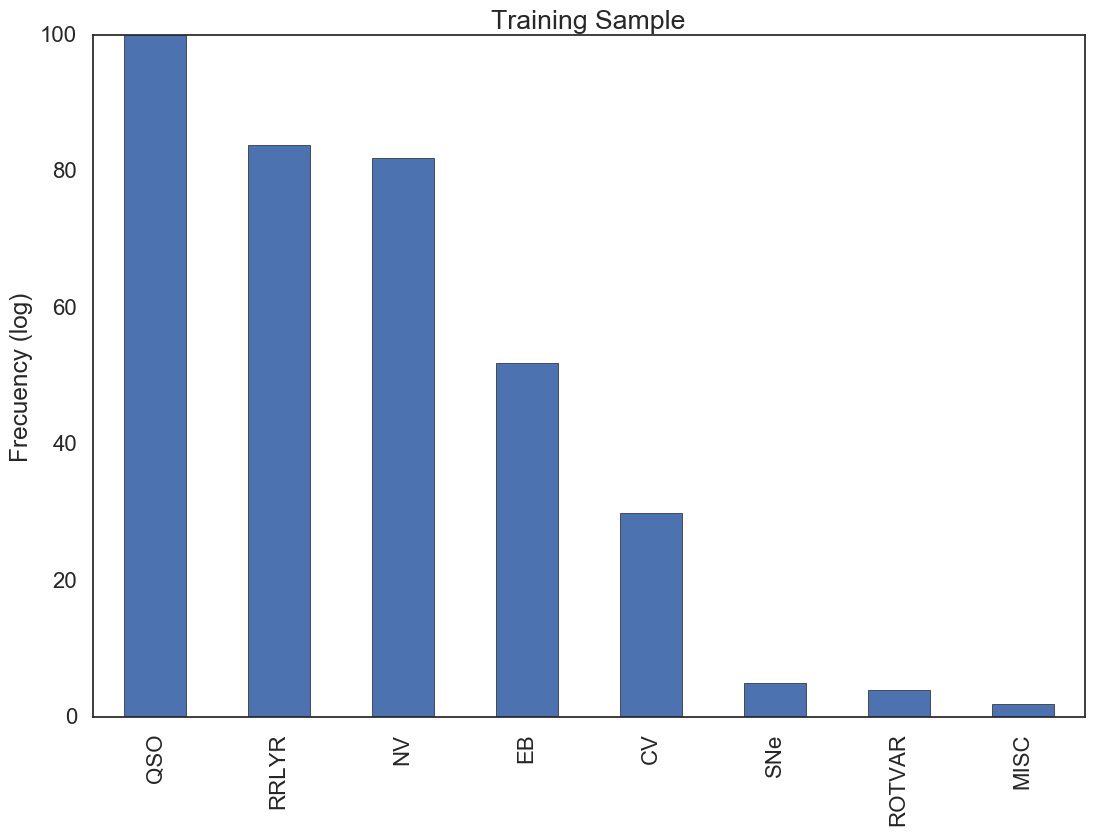

In [63]:
train_sample.Var_Type.value_counts().plot(kind="bar")
plt.ylabel('Frecuency (log)')
#plt.yscale('log')
plt.title('Training Sample')
plt.ylim(0,100)
plt.show()

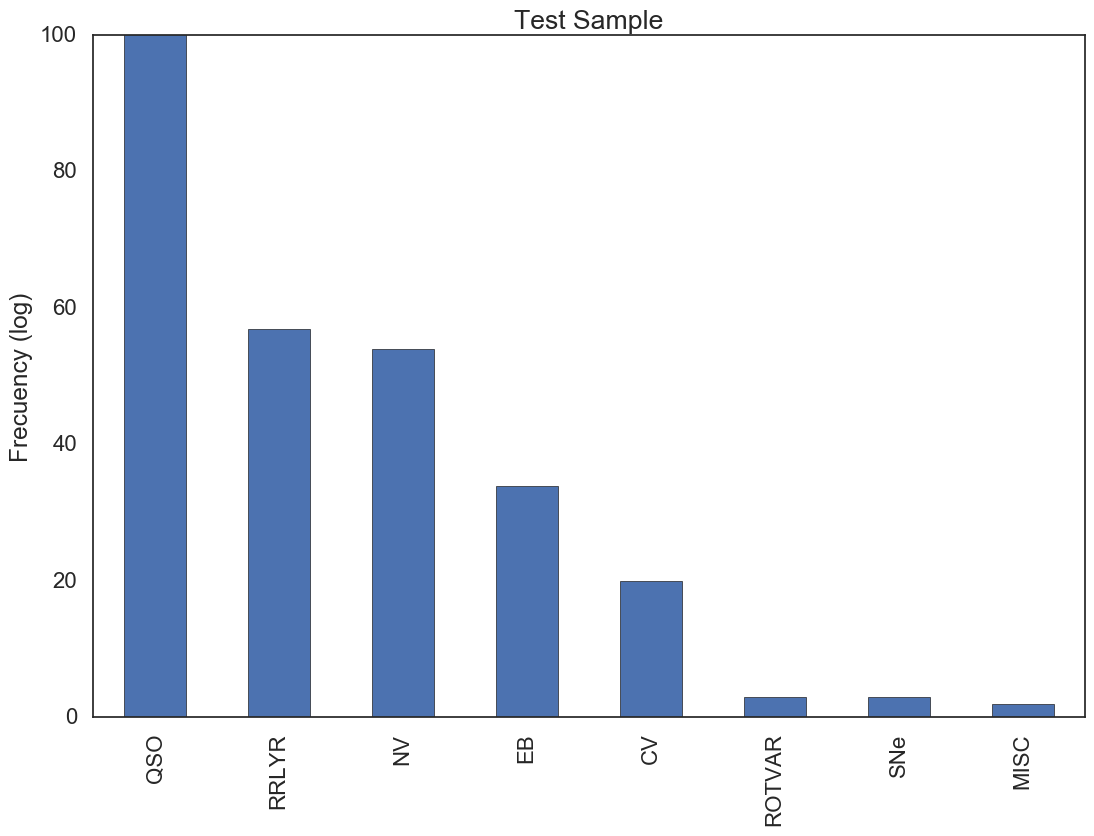

In [64]:
test_sample.Var_Type.value_counts().plot(kind="bar")
plt.ylabel('Frecuency (log)')
#plt.yscale('log')
plt.ylim(0,100)
plt.title('Test Sample')
plt.show()

In [65]:
# PCA reduntion of dimensionality to 5 dim
#reduced_dat = PCA(n_components=5).fit_transform(sub_table_15[feat[18:79]])
#print reduced_dat.shape
#reduced_df = pd.DataFrame(reduced_dat, index = range(len(reduced_dat)))

In [66]:
# gridplot with new 5 dimensions 
#p = sns.PairGrid(reduced_df)
#p.map_diag(plt.hist)
#p.map_offdiag(plt.scatter)
#plt.show()

## Getting Feature importances

In [68]:
RFC = RandomForestClassifier(n_estimators=500, criterion='gini',
                           max_features='sqrt', max_depth=10, n_jobs=3,
                            min_samples_leaf=1, oob_score=True,
                            class_weight='balanced_subsample')
FEAT_RANK = []
for k in range(10):
    print '\r %i' % (k+1),
    RFC.fit(label_samp[FATS_feats], label_samp['Var_Type'])
    FEAT_RANK.append(RFC.feature_importances_)
    
FEAT_RANK = np.mean(np.array(FEAT_RANK), axis=0)

 10


In [69]:
sorted_FATS_feats = pd.DataFrame(np.array([FATS_feats, FEAT_RANK]).T,
                    columns=['FEATURES','Score'])
sorted_FATS_feats.sort_values('Score', ascending=False, inplace=True)
print sorted_FATS_feats.FEATURES.values

['Psi_eta' 'Freq1_harmonics_amplitude_0' 'Period_fit' 'PeriodWMCC_conf'
 'Q31' 'Eta_e' 'Std' 'Rcs' 'CAR_tau' 'r-i' 'PeriodGLS' 'Meanvariance'
 'Mean' 'MaxSlope' 'LinearTrend' 'PeriodWMCC' 'Amplitude' 'PeriodLS'
 'Freq2_harmonics_amplitude_0' 'Freq3_harmonics_amplitude_0' 'CAR_mean'
 'MedianAbsDev' 'PercentDifferenceFluxPercentile'
 'Freq2_harmonics_amplitude_3' 'g-i' 'SlottedA_length' 'g-r'
 'PercentAmplitude' 'Freq2_harmonics_amplitude_1' 'Autocor_length' 'Gskew'
 'Freq2_harmonics_amplitude_2' 'Freq1_harmonics_amplitude_2' 'Skew'
 'Freq3_harmonics_amplitude_1' 'CAR_sigma' 'Freq1_harmonics_amplitude_1'
 'Freq1_harmonics_amplitude_3' 'Freq3_harmonics_amplitude_2'
 'Freq1_harmonics_rel_phase_2' 'Freq2_harmonics_rel_phase_2'
 'Freq3_harmonics_amplitude_3' 'Freq1_harmonics_rel_phase_3' 'StetsonK_AC'
 'SmallKurtosis' 'Freq1_harmonics_rel_phase_1' 'PairSlopeTrend'
 'AndersonDarling' 'Beyond1Std' 'Freq2_harmonics_rel_phase_1'
 'FluxPercentileRatioMid50' 'FluxPercentileRatioMid65' 'StetsonK' '

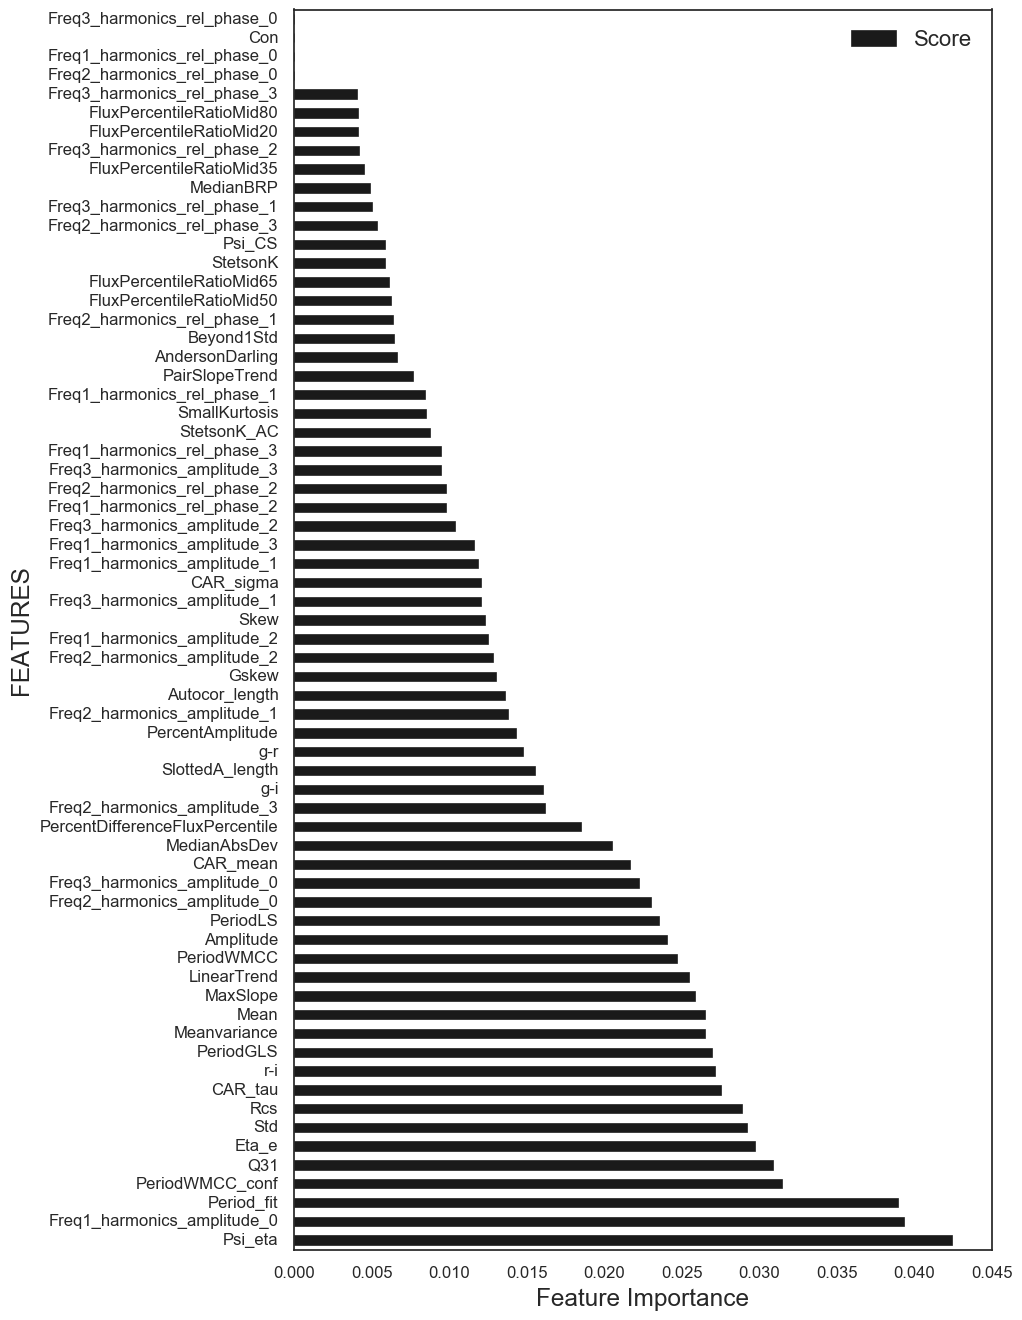

In [70]:
sorted_FATS_feats.plot.barh(x='FEATURES', y='Score', figsize=(9,16), fontsize=12, color='k')
plt.xlabel('Feature Importance')
plt.savefig('%s/feat_importance.pdf' % paper_fig_path, format='pdf', dpi=600,
            bbox_inches='tight')

## How F1 score improve as features are added

In [17]:
RFC = RandomForestClassifier(n_estimators=500, criterion='gini',
                           max_features='sqrt', max_depth=10, n_jobs=3,
                            min_samples_leaf=1, oob_score=True,
                            class_weight='balanced_subsample')
f1s = []
for k in range(1,len(FEAT_RANK)+1):
    print '\r %i' % (k+1),
    RFC.fit(train_sample[sorted_FATS_feats.FEATURES[:k]], train_sample['Var_Type'])
    clases = RFC.classes_
    pred_y = RFC.predict(test_sample[sorted_FATS_feats.FEATURES[:k]])
    f1_score = metrics.f1_score(test_sample['Var_Type'],
                                pred_y, average='macro',labels=clases)
    f1s.append(f1_score)

 2

/Users/jorgetil/miniconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


 66


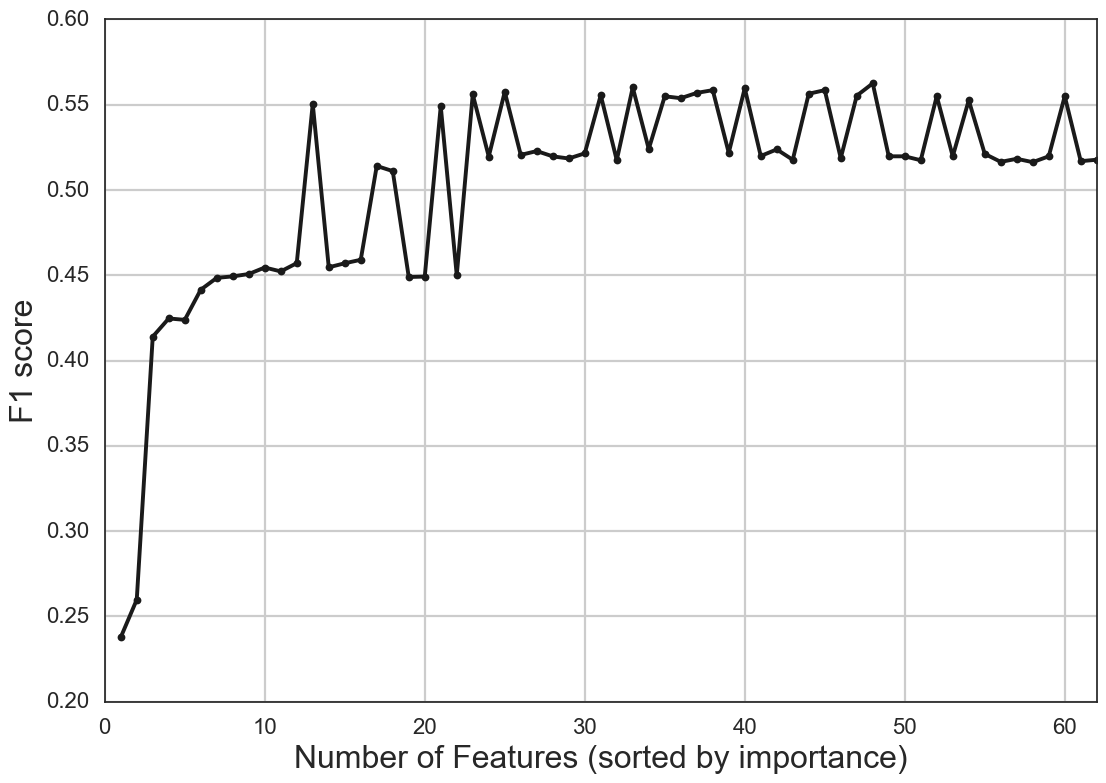

In [18]:
plt.plot(np.arange(len(FEAT_RANK))+1,f1s, 'k.-')
plt.xlabel('Number of Features (sorted by importance)', fontsize='large')
plt.ylabel('F1 score', fontsize='large')
plt.xlim(0,62)
plt.grid(True)
plt.savefig('%s/F1_vs_nfeat.pdf' % paper_fig_path, format='pdf', dpi=600,
            bbox_inches='tight')
plt.show()

## RFC with final params

In [19]:
n_feat = 40
RFC = RandomForestClassifier(n_estimators=1000, criterion='gini',
                           max_features='sqrt', max_depth=10, n_jobs=2,
                            min_samples_leaf=1, oob_score=True,
                            class_weight='balanced_subsample')
ss = model_selection.StratifiedShuffleSplit(n_splits=10, train_size=1./3.)

scores = model_selection.cross_val_score(RFC, label_samp[sorted_FATS_feats.FEATURES[:n_feat]],
                                          label_samp['Var_Type'], scoring='f1_macro', cv=ss,
                                          n_jobs=2, verbose=1)
#RFC.fit(train_sample[sorted_FATS_feats.FEATURES[:n_feat]], train_sample['Var_Type'])

[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:  1.0min finished


In [20]:
#score = RFC.score(test_sample[sorted_FATS_feats.FEATURES[:n_feat]], test_sample['Var_Type'])
#clases = RFC.classes_
#y_prob = RFC.predict_proba(test_sample[sorted_FATS_feats.FEATURES[:n_feat]])
#test_sample['Pred_Var_Type'] = RFC.predict(test_sample[sorted_FATS_feats.FEATURES[:n_feat]])
clases = list(set(label_samp['Var_Type']))
prediction = model_selection.cross_val_predict(RFC, 
                                    label_samp[sorted_FATS_feats.FEATURES[:n_feat]],
                                   label_samp['Var_Type'], cv=10, n_jobs=2, verbose=1)

/Users/jorgetil/miniconda2/lib/python2.7/site-packages/sklearn/model_selection/_split.py:579: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:  1.0min finished


In [21]:
print label_samp[sorted_FATS_feats.FEATURES[:n_feat]].shape
print prediction.shape

(2282, 40)
(2282,)


In [42]:
def conf_matrix(true=[], predict=[], classes=[], normalized=True, save=False,
                matrix_ready=False, matrix=[], class_names='same'):
    classes = sorted(classes)
    if not matrix_ready:
        cm = metrics.confusion_matrix(true, predict, labels=classes)
    else:
        cm = matrix
    if len(classes) < 4:
        font_size = 'large'
        figsize = (7,5)
    else:
        font_size = 'small'
        figsize = (9,7)
    fig, ax = plt.subplots(figsize=figsize)
    if class_names != 'same':
        classes = class_names
    if normalized:
        cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        sns.heatmap(cm_normalized, annot=True, fmt='.2f', linewidths=.5,
                    xticklabels=classes, yticklabels=classes, cmap="GnBu",
                    annot_kws={'size': font_size}, ax=ax)
    else:
        sns.heatmap(cm, annot=True, fmt='d', linewidths=.5,
                    xticklabels=classes, yticklabels=classes, cmap="GnBu",
                    annot_kws={'size': font_size}, ax=ax)
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')
    if save != False:
        plt.savefig(save, format='pdf', dpi=600,
            bbox_inches='tight')
    else:
        plt.title('Confusion Matrix for RF classifier')
    plt.show()

F1-score =  0.55329003061 +- 0.0581174093993
F1-score in test set: 	0.932915
Macro-Precision score: 0.550549684483
Accuracy score: 0.945223488168
             precision    recall  f1-score   support

         CV       0.00      0.00      0.00        50
         EB       0.91      0.90      0.90        86
       MISC       0.00      0.00      0.00         4
         NV       0.85      0.86      0.86       136
        QSO       0.96      0.99      0.97      1850
     ROTVAR       0.00      0.00      0.00         7
      RRLYR       0.94      0.96      0.95       141
        SNe       0.75      0.38      0.50         8

avg / total       0.92      0.95      0.93      2282

/Users/jorgetil/Astro/HITS/figures/conf_matrix_multiclassTest_RFC.pdf


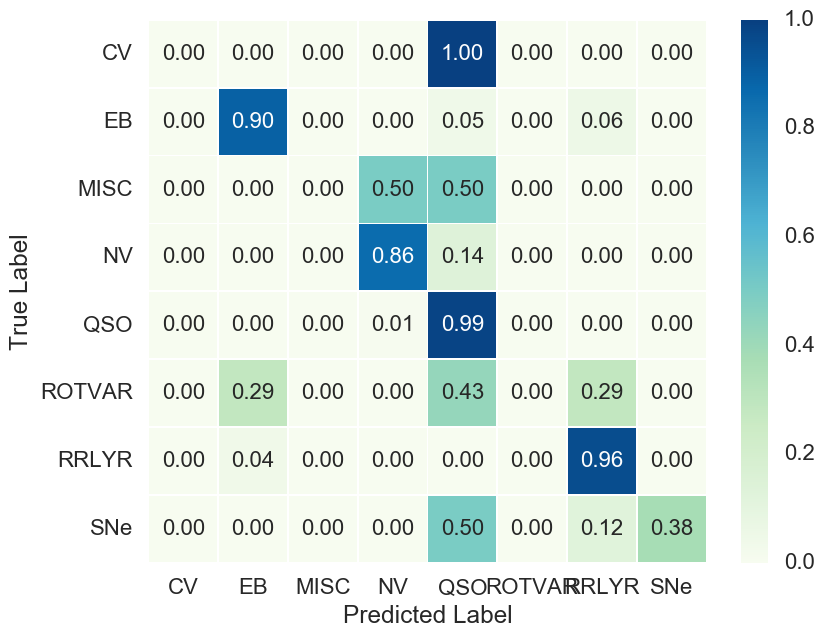

In [41]:
#print 'Score in test set: \t%f' % (scores)
print "F1-score = ", scores.mean(), "+-", scores.std()
print 'F1-score in test set: \t%f' % (metrics.f1_score(label_samp['Var_Type'],
                                    prediction,
                                    average='weighted',labels=clases))
print 'Macro-Precision score:',
print metrics.precision_score(label_samp['Var_Type'], prediction, average='macro')
print 'Accuracy score:',
print metrics.accuracy_score(label_samp['Var_Type'], prediction)

print metrics.classification_report(label_samp['Var_Type'], prediction)
save_path = '%s/figures/conf_matrix_multiclassTest_RFC.pdf' % (mainpath)
conf_matrix(true=label_samp['Var_Type'].values, predict=prediction, classes=clases,
            save=save_path, normalized=True)

## Predict in target sample 2015

In [43]:
target_file = '%s/tables/Blind15A_full_features.csv' % (mainpath)
#target_set = Table.read(target_file, format='fits')
#target_set = target_set.to_pandas()
target_set = pd.read_csv(target_file)
target_set.set_index('internalID', inplace=True)

/Users/jorgetil/miniconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (72,73,74,75) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [44]:
target_set.head()

,ID,X,Y,raMedian,decMedian,Amplitude,AndersonDarling,Autocor_length,Beyond1Std,CAR_mean,...,Std,StetsonK,StetsonK_AC,g-i,g-r,r-i,spCl,subClass,Var_Type,Var_subType
internalID,,,,,,,,,,,,,,,,,,,,,
Blind15A_01_N1_0020_2276,HiTS090949-061817,20.976351,2276.169180,137.457991,-6.304942,0.210095,0.899831,1.0,0.266667,38.136708,...,0.107519,0.746494,0.794400,NaN,1.362971,NaN,NaN,NaN,NaN,NaN
Blind15A_01_N1_0033_2491,HiTS090953-061821,33.938477,2491.236542,137.473741,-6.305966,0.424545,0.966198,1.0,0.300000,163.489669,...,0.211557,0.785690,0.800489,NaN,0.237535,NaN,NaN,NaN,NaN,NaN
Blind15A_01_N1_0034_0966,HiTS090926-061819,34.787000,966.711182,137.362044,-6.305471,0.248623,0.861263,1.0,0.400000,37.727848,...,0.163338,0.842481,0.731029,NaN,0.592017,NaN,NaN,NaN,NaN,NaN
Blind15A_01_N1_0037_2547,HiTS090954-061822,37.712652,2547.588871,137.477868,-6.306263,0.382665,0.960402,1.0,0.157895,38.408224,...,0.162555,0.865397,0.728497,NaN,0.581920,NaN,NaN,NaN,NaN,NaN
Blind15A_01_N1_0041_1375,HiTS090934-061821,41.264858,1375.469397,137.391997,-6.306096,0.123811,0.209898,1.0,0.318182,1633.283087,...,0.068102,0.768905,0.834968,NaN,0.398272,NaN,NaN,NaN,NaN,NaN


In [45]:
target_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1966128 entries, Blind15A_01_N1_0020_2276 to Blind15A_50_S31_2021_2882
Data columns (total 75 columns):
ID                                 object
X                                  float64
Y                                  float64
raMedian                           float64
decMedian                          float64
Amplitude                          float64
AndersonDarling                    float64
Autocor_length                     float64
Beyond1Std                         float64
CAR_mean                           float64
CAR_sigma                          float64
CAR_tau                            float64
Con                                float64
Eta_e                              float64
FluxPercentileRatioMid20           float64
FluxPercentileRatioMid35           float64
FluxPercentileRatioMid50           float64
FluxPercentileRatioMid65           float64
FluxPercentileRatioMid80           float64
Freq1_harmonics_amplitude_0        

In [46]:
# load feature table into DF
table_file = '%s/tables/Blind15A_label_sample_new_PS.csv'\
              %(mainpath)
label_samp = pd.read_csv(table_file)
label_samp = label_samp.set_index('internalID')
label_samp.dropna(subset=FATS_feats, inplace=True)

In [47]:
target_set.dropna(subset=FATS_feats, inplace=True)
target_set = target_set[target_set.Var_Type.isnull()]
target_set.sort_index(inplace=True)

In [48]:
target_set.head()

,ID,X,Y,raMedian,decMedian,Amplitude,AndersonDarling,Autocor_length,Beyond1Std,CAR_mean,...,Std,StetsonK,StetsonK_AC,g-i,g-r,r-i,spCl,subClass,Var_Type,Var_subType
internalID,,,,,,,,,,,,,,,,,,,,,
Blind15A_02_N10_0046_0180,HiTS090743-042818,46.425090,180.720626,136.930012,-4.471799,0.239606,0.999931,1.0,0.190476,1357.041962,...,0.144664,0.701148,0.739501,0.454233,0.215342,0.238891,NaN,NaN,NaN,NaN
Blind15A_02_N10_0051_2746,HiTS090828-042821,51.334615,2746.151886,137.118423,-4.472669,0.165154,0.943850,1.0,0.192308,413.551394,...,0.080065,0.788738,0.613651,0.778938,0.628516,0.150422,NaN,NaN,NaN,NaN
Blind15A_02_N10_0061_1167,HiTS090800-042823,61.253305,1167.914492,137.002488,-4.473094,0.059031,0.574999,1.0,0.240000,34.198530,...,0.032011,0.852284,0.806176,0.731667,0.510303,0.221363,NaN,NaN,NaN,NaN
Blind15A_02_N10_0062_3104,HiTS090834-042824,62.837584,3104.422529,137.144745,-4.473575,0.030603,0.874582,1.0,0.481481,4978.000467,...,0.018729,0.821946,0.787934,1.358737,0.998493,0.360243,NaN,NaN,NaN,NaN
Blind15A_02_N10_0063_0131,HiTS090742-042822,63.313291,131.735671,136.926414,-4.473025,0.028794,0.903372,1.0,0.346154,4165.084422,...,0.015654,0.797898,0.763585,0.684382,0.514148,0.170235,NaN,NaN,NaN,NaN


In [49]:
print FATS_feats

['Amplitude' 'AndersonDarling' 'Autocor_length' 'Beyond1Std' 'CAR_mean'
 'CAR_sigma' 'CAR_tau' 'Con' 'Eta_e' 'FluxPercentileRatioMid20'
 'FluxPercentileRatioMid35' 'FluxPercentileRatioMid50'
 'FluxPercentileRatioMid65' 'FluxPercentileRatioMid80'
 'Freq1_harmonics_amplitude_0' 'Freq1_harmonics_amplitude_1'
 'Freq1_harmonics_amplitude_2' 'Freq1_harmonics_amplitude_3'
 'Freq1_harmonics_rel_phase_0' 'Freq1_harmonics_rel_phase_1'
 'Freq1_harmonics_rel_phase_2' 'Freq1_harmonics_rel_phase_3'
 'Freq2_harmonics_amplitude_0' 'Freq2_harmonics_amplitude_1'
 'Freq2_harmonics_amplitude_2' 'Freq2_harmonics_amplitude_3'
 'Freq2_harmonics_rel_phase_0' 'Freq2_harmonics_rel_phase_1'
 'Freq2_harmonics_rel_phase_2' 'Freq2_harmonics_rel_phase_3'
 'Freq3_harmonics_amplitude_0' 'Freq3_harmonics_amplitude_1'
 'Freq3_harmonics_amplitude_2' 'Freq3_harmonics_amplitude_3'
 'Freq3_harmonics_rel_phase_0' 'Freq3_harmonics_rel_phase_1'
 'Freq3_harmonics_rel_phase_2' 'Freq3_harmonics_rel_phase_3' 'Gskew'
 'LinearTrend'

In [57]:
RFC.fit(label_samp[sorted_FATS_feats.FEATURES[:n_feat]], label_samp['Var_Type'])

joblib.dump(RFC, '%s/models/RFC_all_multiclass.pkl' % mainpath)  

['/Users/jorgetil/Astro/HITS/models/RFC_all_multiclass.pkl']

In [51]:
Pred_Var_Type = []
prob_target = []
chunks = range(0,len(target_set), 10000)
for kk in range(len(chunks)-1):
    print chunks[kk],':',chunks[kk+1],'|',
    Pred_Var_Type__ = RFC.predict(target_set.iloc[chunks[kk]:chunks[kk+1]][sorted_FATS_feats.FEATURES[:n_feat]])
    prob_target__ = RFC.predict_proba(target_set.iloc[chunks[kk]:chunks[kk+1]][sorted_FATS_feats.FEATURES[:n_feat]])
    Pred_Var_Type.extend(Pred_Var_Type__)
    prob_target.extend(prob_target__)
    #if kk == 10: break
print chunks[kk+1],':',len(target_set)
Pred_Var_Type__ = RFC.predict(target_set.iloc[chunks[kk+1]:][sorted_FATS_feats.FEATURES[:n_feat]])
prob_target__ = RFC.predict_proba(target_set.iloc[chunks[kk+1]:][sorted_FATS_feats.FEATURES[:n_feat]])
Pred_Var_Type.extend(Pred_Var_Type__)
prob_target.extend(prob_target__)
Pred_Var_Type = np.asarray(Pred_Var_Type)
prob_target = np.asarray(prob_target)

print Pred_Var_Type.shape
print prob_target.shape

0 : 10000 | 10000 : 20000 | 20000 : 30000 | 30000 : 40000 | 40000 : 50000 | 50000 : 60000 | 60000 : 70000 | 70000 : 80000 | 80000 : 90000 | 90000 : 100000 | 100000 : 110000 | 110000 : 120000 | 120000 : 130000 | 130000 : 140000 | 140000 : 150000 | 150000 : 160000 | 160000 : 170000 | 170000 : 180000 | 180000 : 190000 | 190000 : 200000 | 200000 : 210000 | 210000 : 220000 | 220000 : 230000 | 230000 : 240000 | 240000 : 250000 | 250000 : 260000 | 260000 : 270000 | 270000 : 280000 | 280000 : 290000 | 290000 : 300000 | 300000 : 310000 | 310000 : 320000 | 320000 : 330000 | 330000 : 340000 | 340000 : 350000 | 350000 : 360000 | 360000 : 370000 | 370000 : 380000 | 380000 : 390000 | 390000 : 400000 | 400000 : 410000 | 410000 : 420000 | 420000 : 430000 | 430000 : 440000 | 440000 : 450000 | 450000 : 460000 | 460000 : 470000 | 470000 : 480000 | 480000 : 490000 | 490000 : 500000 | 500000 : 510000 | 510000 : 520000 | 520000 : 530000 | 530000 : 540000 | 540000 : 550000 | 550000 : 560000 | 560000 : 570000

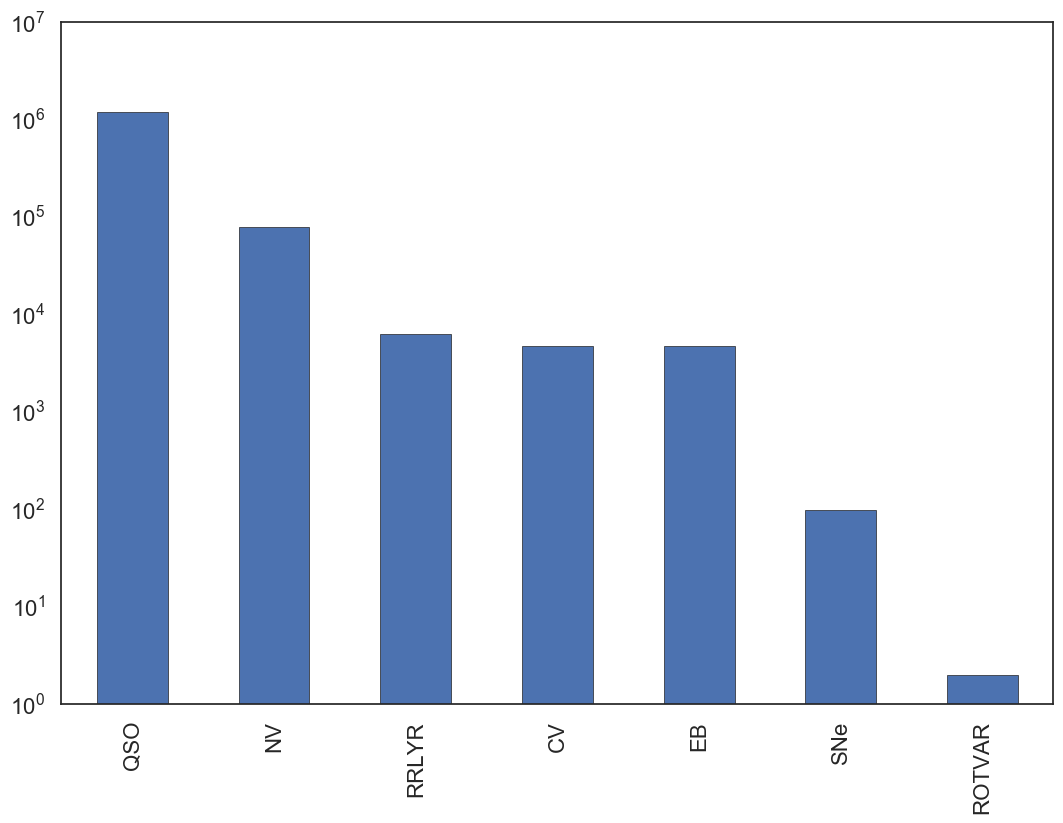

In [52]:
Pred_Var_Type = pd.Series(Pred_Var_Type, index=target_set.index)
Pred_Var_Type.value_counts().plot(kind="bar")
plt.yscale('log')

['CV' 'DSCT' 'EB' 'LPV' 'MISC' 'NV' 'QSO' 'ROTVAR' 'RRLYR' 'SNe' 'ZZ']


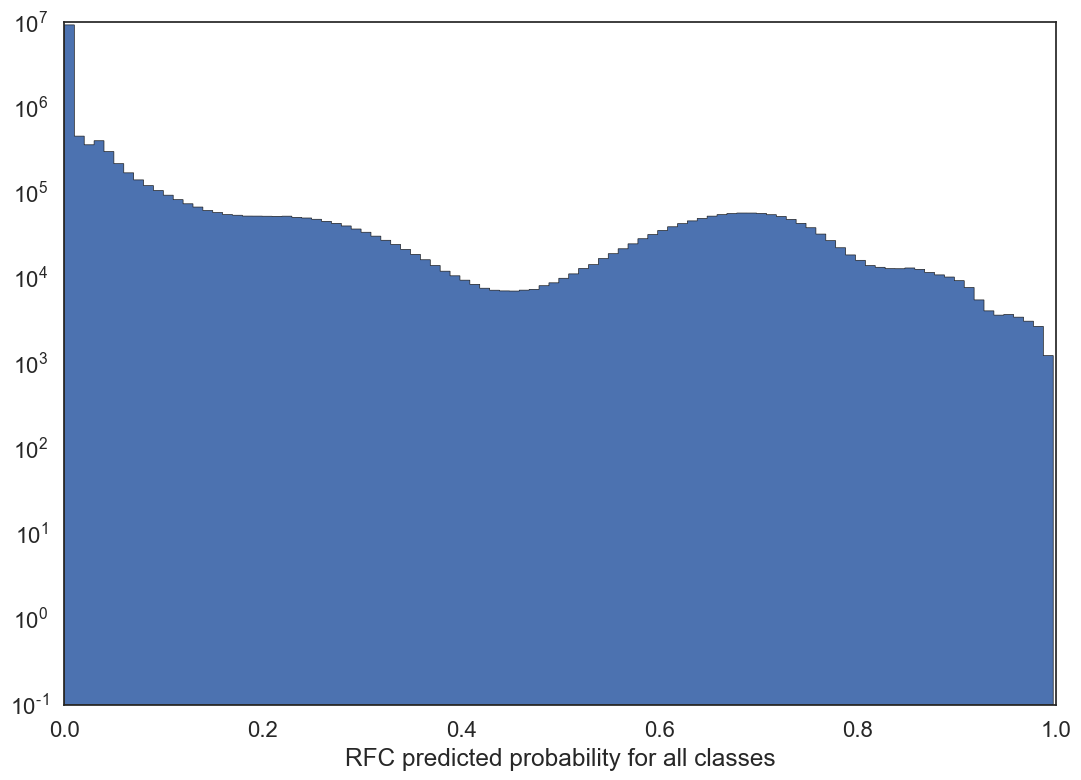

In [53]:
clases = RFC.classes_
print clases
prob_target = pd.DataFrame(prob_target, index=target_set.index, columns=clases)
plt.hist(prob_target.values.ravel(),bins=100,histtype='stepfilled',color='b', log=True)
plt.xlabel('RFC predicted probability for all classes')
plt.show()

In [54]:
target_set['Prob_Pred'] = None
target_set['Pred_Var_Type'] = None
for k,clas in enumerate(prob_target.columns):
    print 'Class: %s\t| ' % (clas),
    print 'Max prob of all entries: ', prob_target[clas].max()
    
    index_best_ten = prob_target[clas].nlargest(n=10).index.values
    mask_best_ten = (prob_target.loc[index_best_ten].idxmax(axis=1) == clas).values
    
    target_set.loc[index_best_ten[mask_best_ten],'Pred_Var_Type'] = clas
    target_set.loc[index_best_ten[mask_best_ten],'Prob_Pred'] =\
                                prob_target.loc[index_best_ten[mask_best_ten],clas].values
    print prob_target.loc[index_best_ten[mask_best_ten]]
    print target_set.loc[index_best_ten[mask_best_ten],['Pred_Var_Type','Prob_Pred']]
    print '____________________________'

Class: CV	|  Max prob of all entries:  0.650243399372
                                 CV  DSCT        EB  LPV  MISC        NV  \
internalID                                                                 
Blind15A_08_N8_1901_0114   0.650243   0.0  0.019174  0.0   0.0  0.000804   
Blind15A_44_N2_1901_3989   0.633571   0.0  0.021567  0.0   0.0  0.000639   
Blind15A_49_N18_1890_0954  0.627167   0.0  0.018015  0.0   0.0  0.000430   
Blind15A_39_S21_0544_0511  0.623198   0.0  0.017947  0.0   0.0  0.000593   
Blind15A_20_S31_1556_3415  0.620016   0.0  0.029800  0.0   0.0  0.000434   
Blind15A_26_S15_0335_1712  0.617373   0.0  0.019063  0.0   0.0  0.000573   
Blind15A_29_S15_0441_0296  0.616189   0.0  0.015497  0.0   0.0  0.000523   
Blind15A_50_S26_1117_0832  0.614157   0.0  0.016516  0.0   0.0  0.001213   
Blind15A_47_S12_0179_1003  0.613845   0.0  0.020417  0.0   0.0  0.000696   
Blind15A_06_S19_0299_2551  0.613047   0.0  0.020272  0.0   0.0  0.000758   

                                Q

In [55]:
best_pred = target_set.dropna(subset=['Pred_Var_Type','Prob_Pred'])
best_pred.to_csv('%s/tables/Blind15A_candidates_from_HiTS.csv'
                        % (mainpath))

# Predict on target sample 2014

In [82]:
target_file = '%s/tables/Blind14A_tables+feat_pl_var_type_spCL_spClass.csv' % (mainpath)
target_set = pd.read_csv(target_file, index_col=0)

In [99]:
print target_set.shape
target_set.head()

(963350, 79)


,DEC,ELLIPTICITY,FLAGS,FLUX_RADIUS,FWHM,KRON_RADIUS,Median_err_g,Median_g,Occu_g,RA,...,SmallKurtosis,Std,StetsonK,StetsonK_AC,WMCC_Period,WMCC_conf,spCl,subClass,Var_Type,Var_subType
ID,,,,,,,,,,,,,,,,,,,,,
Blind14A_01_N10_0020_1882,-2.270983,0.032882,0,2.6910,5.070,3.500,0.033699,19.847599,19,152.020936,...,3.886018,0.029290,0.774515,0.813359,0.334987,0.564320,NaN,NaN,NaN,NaN
Blind14A_01_N10_0023_2501,-2.271289,0.061914,3,2.9220,5.400,3.500,0.036309,20.326938,19,152.066298,...,1.819491,0.050336,0.875120,0.728035,0.281165,0.685354,NaN,NaN,NaN,NaN
Blind14A_01_N10_0027_2451,-2.271603,0.066293,0,2.4980,5.940,3.500,0.070576,22.087639,23,152.062665,...,5.291238,0.173996,0.685260,0.667112,0.011916,0.583393,NaN,NaN,NaN,NaN
Blind14A_01_N10_0032_1010,-2.271698,0.145299,1,3.5495,8.025,5.575,0.141754,22.696010,20,151.957069,...,4.577859,0.223963,0.739918,0.719322,0.021132,0.671527,NaN,NaN,NaN,NaN
Blind14A_01_N10_0032_1064,-2.271745,0.069764,1,2.6775,5.665,3.500,0.052727,21.509803,28,151.960965,...,3.861645,0.120717,0.781195,0.569239,0.011982,0.618929,NaN,NaN,NaN,NaN


In [100]:
sorted_FATS_feats_14 = sorted_FATS_feats[sorted_FATS_feats.FEATURES != 'Color']
target_set.dropna(subset=sorted_FATS_feats_14.FEATURES.values, inplace=True)
target_set = target_set[target_set.Var_Type.isnull()]
target_set.sort_index(inplace=True)
print target_set.shape

(963350, 79)


In [101]:
target_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 963350 entries, Blind14A_01_N10_0020_1882 to Blind14A_40_S9_2013_0916
Data columns (total 79 columns):
DEC                                963350 non-null float64
ELLIPTICITY                        963350 non-null float64
FLAGS                              963350 non-null int64
FLUX_RADIUS                        963350 non-null float64
FWHM                               963350 non-null float64
KRON_RADIUS                        963350 non-null float64
Median_err_g                       963350 non-null float64
Median_g                           963350 non-null float64
Occu_g                             963350 non-null int64
RA                                 963350 non-null float64
STD_g                              963350 non-null float64
X                                  963350 non-null float64
Y                                  963350 non-null float64
Amplitude                          963350 non-null float64
AndersonDarling               

In [103]:
RFC.fit(label_samp[sorted_FATS_feats_14.FEATURES[:n_feat]], label_samp['Var_Type'])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='sqrt', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=2,
            oob_score=True, random_state=None, verbose=0, warm_start=False)

In [107]:
Pred_Var_Type = []
prob_target = []
chunks = range(0,len(target_set), 10000)
for kk in range(len(chunks)-1):
    print chunks[kk],':',chunks[kk+1],'|',
    Pred_Var_Type__ = RFC.predict(target_set.iloc[chunks[kk]:chunks[kk+1]][sorted_FATS_feats_14.FEATURES[:n_feat]])
    prob_target__ = RFC.predict_proba(target_set.iloc[chunks[kk]:chunks[kk+1]][sorted_FATS_feats_14.FEATURES[:n_feat]])
    Pred_Var_Type.extend(Pred_Var_Type__)
    prob_target.extend(prob_target__)
    #if kk == 10: break
print chunks[kk+1],':',len(target_set)
Pred_Var_Type__ = RFC.predict(target_set.iloc[chunks[kk+1]:][sorted_FATS_feats_14.FEATURES[:n_feat]])
prob_target__ = RFC.predict_proba(target_set.iloc[chunks[kk+1]:][sorted_FATS_feats_14.FEATURES[:n_feat]])
Pred_Var_Type.extend(Pred_Var_Type__)
prob_target.extend(prob_target__)
Pred_Var_Type = np.asarray(Pred_Var_Type)
prob_target = np.asarray(prob_target)

print Pred_Var_Type.shape
print prob_target.shape

 0 : 10000 | 10000 : 20000 | 20000 : 30000 | 30000 : 40000 | 40000 : 50000 | 50000 : 60000 | 60000 : 70000 | 70000 : 80000 | 80000 : 90000 | 90000 : 100000 | 100000 : 110000 | 110000 : 120000 | 120000 : 130000 | 130000 : 140000 | 140000 : 150000 | 150000 : 160000 | 160000 : 170000 | 170000 : 180000 | 180000 : 190000 | 190000 : 200000 | 200000 : 210000 | 210000 : 220000 | 220000 : 230000 | 230000 : 240000 | 240000 : 250000 | 250000 : 260000 | 260000 : 270000 | 270000 : 280000 | 280000 : 290000 | 290000 : 300000 | 300000 : 310000 | 310000 : 320000 | 320000 : 330000 | 330000 : 340000 | 340000 : 350000 | 350000 : 360000 | 360000 : 370000 | 370000 : 380000 | 380000 : 390000 | 390000 : 400000 | 400000 : 410000 | 410000 : 420000 | 420000 : 430000 | 430000 : 440000 | 440000 : 450000 | 450000 : 460000 | 460000 : 470000 | 470000 : 480000 | 480000 : 490000 | 490000 : 500000 | 500000 : 510000 | 510000 : 520000 | 520000 : 530000 | 530000 : 540000 | 540000 : 550000 | 550000 : 560000 | 560000 : 57000

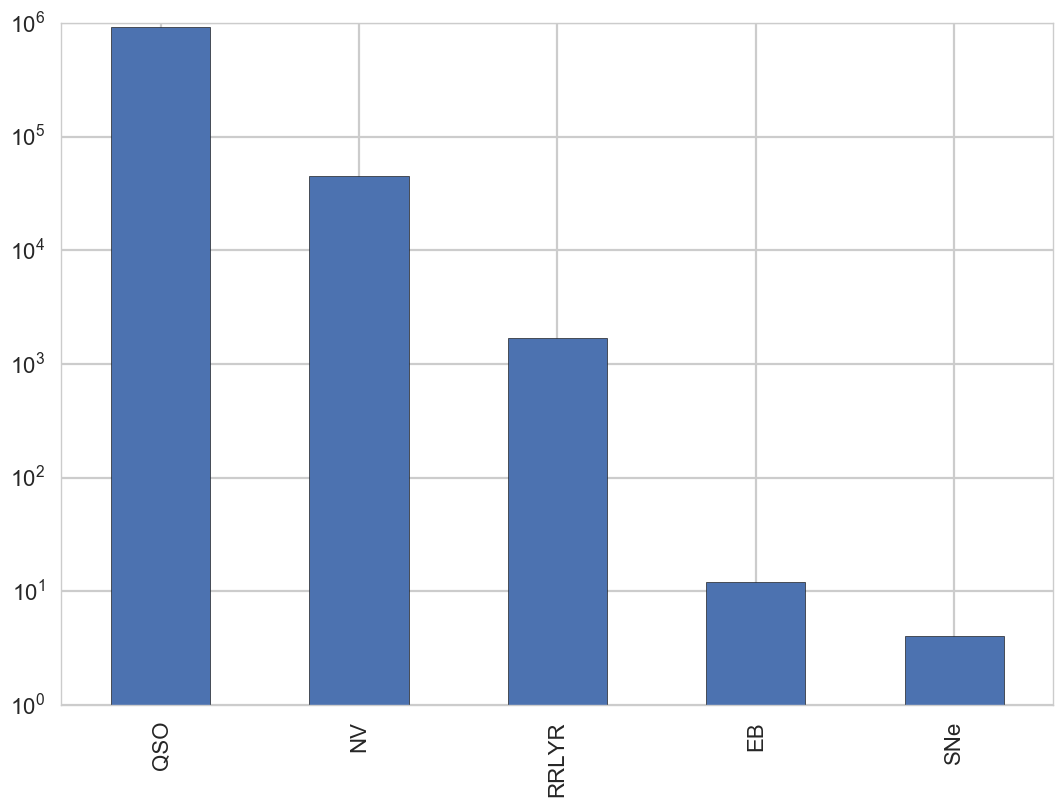

In [108]:
Pred_Var_Type = pd.Series(Pred_Var_Type, index=target_set.index)
Pred_Var_Type.value_counts().plot(kind="bar")
plt.yscale('log')

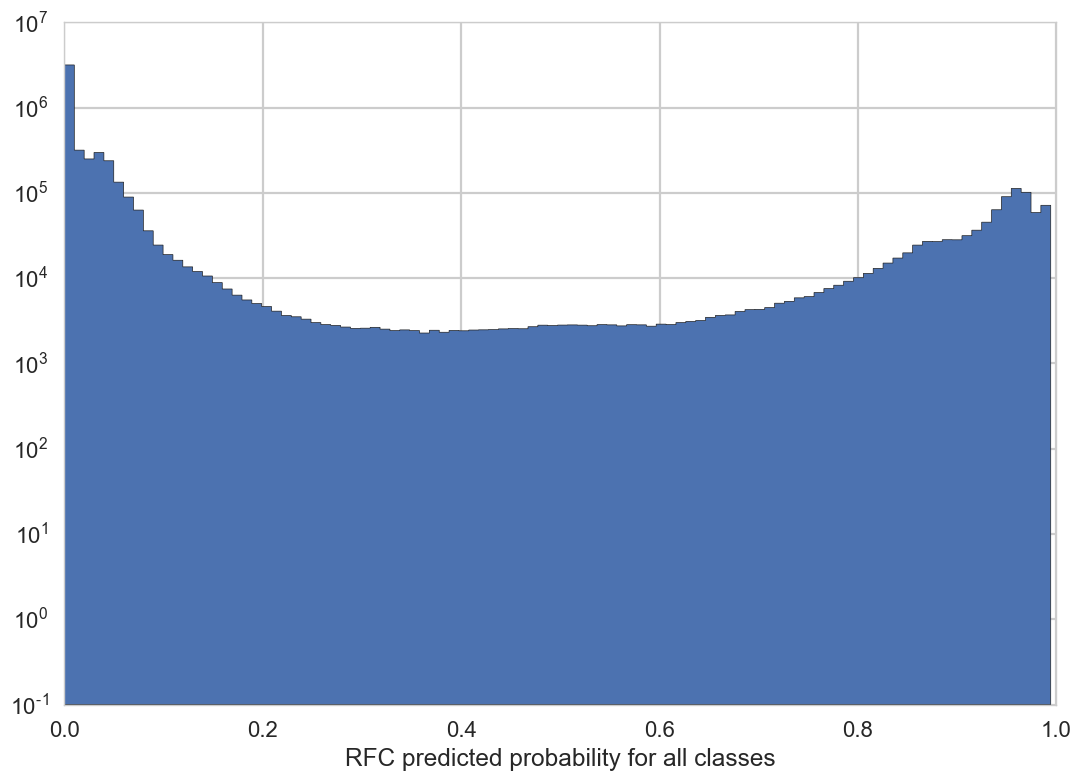

In [110]:
prob_target = pd.DataFrame(prob_target, index=target_set.index, columns=clases)
plt.hist(prob_target.values.ravel(),bins=100,histtype='stepfilled',color='b', log=True)
plt.xlabel('RFC predicted probability for all classes')
plt.show()

In [111]:
target_set['Prob_Pred'] = None
target_set['Pred_Var_Type'] = None
for k,clas in enumerate(prob_target.columns):
    print 'Class: %s\t| ' % (clas),
    print 'Max prob of all entries: ', prob_target[clas].max()
    
    index_best_ten = prob_target[clas].nlargest(n=10).index.values
    mask_best_ten = (prob_target.loc[index_best_ten].idxmax(axis=1) == clas).values
    
    target_set.loc[index_best_ten[mask_best_ten],'Pred_Var_Type'] = clas
    target_set.loc[index_best_ten[mask_best_ten],'Prob_Pred'] =\
                                prob_target.loc[index_best_ten[mask_best_ten],clas].values
    print prob_target.loc[index_best_ten[mask_best_ten]]
    print target_set.loc[index_best_ten[mask_best_ten],['Pred_Var_Type','Prob_Pred']]
    print '____________________________'

Class: CV	|  Max prob of all entries:  0.349455357143
Empty DataFrame
Columns: [CV, EB, NV, QSO, RRLYR, SNe]
Index: []
Empty DataFrame
Columns: [Pred_Var_Type, Prob_Pred]
Index: []
____________________________
Class: EB	|  Max prob of all entries:  0.600286505425
                                 CV        EB        NV       QSO     RRLYR  \
ID                                                                            
Blind14A_07_S1_1505_3093   0.012123  0.600287  0.000000  0.065979  0.317444   
Blind14A_12_N8_0714_0336   0.012748  0.556084  0.000000  0.088742  0.340426   
Blind14A_03_N3_0326_3154   0.005438  0.518940  0.000000  0.077619  0.388001   
Blind14A_10_N21_0658_0266  0.038346  0.436001  0.000000  0.204126  0.314527   
Blind14A_22_S1_1616_1296   0.013506  0.416346  0.000000  0.134482  0.412660   
Blind14A_27_N23_0751_3348  0.017295  0.414021  0.000000  0.187411  0.366089   
Blind14A_01_N10_0277_2768  0.021595  0.408722  0.000001  0.216047  0.351620   

                        

In [112]:
best_pred = target_set.dropna(subset=['Pred_Var_Type','Prob_Pred'])
best_pred.to_csv('%s/tables/Blind14A_candidates_from_HiTS.csv'
                        % (mainpath))

# Pre-processing tables for Jean-Charles 

In [116]:
# load feature table into DF
table_file = '%s/tables/Blind15A_label_sample_new.csv'\
              %(mainpath)
label_samp = pd.read_csv(table_file)
label_samp = label_samp.set_index('ID')
print label_samp.shape

(2940, 86)


In [117]:
# columns with features
print label_samp.shape
feat = label_samp.columns.values
FATS_feats = feat[17:78]
FATS_feats = FATS_feats[FATS_feats!='Mean']
print FATS_feats
label_samp.dropna(subset=FATS_feats, inplace=True)

(2940, 86)
['Amplitude' 'AndersonDarling' 'Autocor_length' 'Beyond1Std' 'CAR_mean'
 'CAR_sigma' 'CAR_tau' 'Color' 'Con' 'Eta_e' 'FluxPercentileRatioMid20'
 'FluxPercentileRatioMid35' 'FluxPercentileRatioMid50'
 'FluxPercentileRatioMid65' 'FluxPercentileRatioMid80'
 'Freq1_harmonics_amplitude_0' 'Freq1_harmonics_amplitude_1'
 'Freq1_harmonics_amplitude_2' 'Freq1_harmonics_amplitude_3'
 'Freq1_harmonics_rel_phase_0' 'Freq1_harmonics_rel_phase_1'
 'Freq1_harmonics_rel_phase_2' 'Freq1_harmonics_rel_phase_3'
 'Freq2_harmonics_amplitude_0' 'Freq2_harmonics_amplitude_1'
 'Freq2_harmonics_amplitude_2' 'Freq2_harmonics_amplitude_3'
 'Freq2_harmonics_rel_phase_0' 'Freq2_harmonics_rel_phase_1'
 'Freq2_harmonics_rel_phase_2' 'Freq2_harmonics_rel_phase_3'
 'Freq3_harmonics_amplitude_0' 'Freq3_harmonics_amplitude_1'
 'Freq3_harmonics_amplitude_2' 'Freq3_harmonics_amplitude_3'
 'Freq3_harmonics_rel_phase_0' 'Freq3_harmonics_rel_phase_1'
 'Freq3_harmonics_rel_phase_2' 'Freq3_harmonics_rel_phase_3' 'Gs

In [213]:
to_JC = target_set[FATS_feats]
to_JC['Var_Type'] = target_set['Var_Type']
to_JC.describe()
#to_JC.to_csv('./HiTS2015A_20feats_vartype.csv')

/Users/jorgetil/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


,Amplitude,AndersonDarling,Autocor_length,Beyond1Std,CAR_mean,CAR_sigma,CAR_tau,Color,Con,Eta_e,...,Psi_CS,Psi_eta,Q31,Rcs,Skew,SlottedA_length,SmallKurtosis,Std,StetsonK,StetsonK_AC
count,1.469318e+06,1.469318e+06,1.469318e+06,1.469318e+06,1.469318e+06,1.469318e+06,1.469318e+06,1.469318e+06,1.469318e+06,1.469318e+06,...,1.469318e+06,1.469318e+06,1.469318e+06,1.469318e+06,1.469318e+06,1.469318e+06,1.469318e+06,1.469318e+06,1.469318e+06,1.469318e+06
mean,2.827954e-01,7.506369e-01,1.058651e+00,2.561591e-01,7.280925e+02,8.602842e-02,2.746315e+10,9.729555e-01,1.189268e-04,4.170211e+02,...,2.613643e-01,1.360330e+00,1.629486e-01,2.333377e-01,1.966032e-01,7.510829e-02,2.403604e+00,1.483883e-01,7.775775e-01,6.879174e-01
std,2.571949e-01,2.690656e-01,2.626601e-01,8.559365e-02,4.893607e+03,3.094551e+00,1.145884e+13,4.961990e-01,2.206698e-03,1.477855e+03,...,4.750011e-02,3.211159e-01,1.596125e-01,5.380342e-02,1.069648e+00,6.263385e-02,3.556022e+00,1.459554e-01,6.999506e-02,7.788075e-02
min,5.850000e-03,8.806045e-02,1.000000e+00,0.000000e+00,-9.519927e-02,-5.544581e+01,-1.462823e+06,-1.431510e+01,0.000000e+00,9.974982e-03,...,1.204810e-01,4.419108e-02,2.000000e-03,7.871943e-02,-4.971523e+00,2.644300e-03,-2.086749e+00,3.476633e-03,2.432862e-01,2.540726e-01
25%,1.209000e-01,5.250076e-01,1.000000e+00,2.000000e-01,3.154184e+01,-4.092010e-02,3.303802e-01,5.799084e-01,0.000000e+00,1.031523e+02,...,2.264427e-01,1.136005e+00,6.180000e-02,1.935930e-01,-3.898608e-01,6.734620e-02,2.212112e-01,6.249840e-02,7.448553e-01,6.412947e-01
50%,2.667500e-01,8.659580e-01,1.000000e+00,2.592593e-01,3.719498e+01,-1.194232e-09,5.949653e-01,9.504215e-01,0.000000e+00,2.127395e+02,...,2.569835e-01,1.345529e+00,1.513500e-01,2.291568e-01,1.688796e-01,6.740250e-02,1.275113e+00,1.436135e-01,7.886903e-01,6.970622e-01
75%,3.859500e-01,9.959878e-01,1.000000e+00,3.157895e-01,6.802769e+01,4.427833e-09,5.951918e-01,1.413396e+00,0.000000e+00,4.188095e+02,...,2.919752e-01,1.568558e+00,2.323000e-01,2.689796e-01,7.620302e-01,6.760040e-02,3.214775e+00,2.034847e-01,8.239858e-01,7.435343e-01
max,1.254902e+01,1.000000e+00,7.000000e+00,7.777778e-01,2.595340e+05,1.530083e+03,7.339275e+15,8.163670e+00,8.333333e-02,1.115288e+05,...,4.946722e-01,3.360191e+00,2.323042e+01,4.949417e-01,5.026178e+00,2.086653e+00,3.070764e+01,1.136734e+01,9.947125e-01,9.825545e-01


In [214]:
to_JC_negpart = to_JC
for feat in FATS_feats:
    #print feat
    if np.min(to_JC_negpart[feat]) < 0:
        name = '%s_negpart' % (feat)
        mask = to_JC_negpart[feat] < 0
        to_JC_negpart[name] = 0
        to_JC_negpart[name][mask] = np.absolute(to_JC_negpart[feat][mask])
        to_JC_negpart[feat][mask] = 0
to_JC_negpart = to_JC_negpart.reindex_axis(sorted(to_JC_negpart.columns), axis=1)
to_JC_negpart

/Users/jorgetil/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/jorgetil/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/jorgetil/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,Amplitude,AndersonDarling,Autocor_length,Beyond1Std,CAR_mean,CAR_mean_negpart,CAR_sigma,CAR_sigma_negpart,CAR_tau,CAR_tau_negpart,...,Rcs,Skew,Skew_negpart,SlottedA_length,SmallKurtosis,SmallKurtosis_negpart,Std,StetsonK,StetsonK_AC,Var_Type
ID,,,,,,,,,,,,,,,,,,,,,
Blind15A_01_N10_0030_3303,0.220650,0.955670,1.0,0.294118,4.029764e+02,0.0,0.000000e+00,2.978382e-01,5.550193e-02,0.0,...,0.298411,0.000000,1.051827,0.068752,2.590990,0.000000,0.107902,0.755964,0.835099,NaN
Blind15A_01_N10_0033_0287,0.297950,0.583588,1.0,0.400000,3.881665e+01,0.0,3.789182e-09,0.000000e+00,5.949201e-01,0.0,...,0.226438,0.000000,0.271103,0.002644,0.000000,0.530671,0.187315,0.823751,0.879604,NaN
Blind15A_01_N10_0033_2017,0.106450,1.000000,2.0,0.105263,2.302801e+01,0.0,3.300612e-02,0.000000e+00,8.770119e-01,0.0,...,0.301169,1.924998,0.000000,0.002644,5.080721,0.000000,0.055226,0.693573,0.565596,NaN
Blind15A_01_N10_0044_0753,0.281650,0.566173,1.0,0.260870,1.876094e+03,0.0,1.223605e+00,0.000000e+00,1.188256e-02,0.0,...,0.150131,0.068185,0.000000,0.002645,1.529320,0.000000,0.141132,0.784443,0.730497,NaN
Blind15A_01_N10_0047_1151,0.210375,0.998529,1.0,0.120000,6.547878e-02,0.0,1.281590e-03,0.000000e+00,3.279433e+02,0.0,...,0.178123,0.000000,1.963916,0.002645,8.090870,0.000000,0.117221,0.823639,0.692592,NaN
Blind15A_01_N10_0047_3847,0.081250,0.999958,1.0,0.280000,3.945896e+02,0.0,1.462249e-01,0.000000e+00,4.957893e-02,0.0,...,0.186974,0.249758,0.000000,0.002645,0.717178,0.000000,0.041010,0.805424,0.702721,NaN
Blind15A_01_N10_0049_1568,0.705500,0.927899,1.0,0.333333,7.495488e+04,0.0,1.996238e+01,0.000000e+00,3.079088e-04,0.0,...,0.229051,0.723350,0.000000,0.067737,1.878948,0.000000,0.333531,0.730678,0.680584,NaN
Blind15A_01_N10_0049_1762,0.402000,0.870070,1.0,0.285714,1.380045e+05,0.0,0.000000e+00,1.585510e+01,1.657282e-04,0.0,...,0.241498,0.525976,0.000000,0.002645,0.545001,0.000000,0.222671,0.786463,0.693552,NaN
Blind15A_01_N10_0050_2059,0.126100,0.999903,1.0,0.200000,3.448389e+01,0.0,3.789182e-09,0.000000e+00,5.949201e-01,0.0,...,0.216275,0.000000,1.456173,0.002645,7.003334,0.000000,0.067118,0.764792,0.635086,NaN


In [215]:
to_JC_negpart.to_csv('./HiTS2015A_full_allfeats_vartype_negpart.csv')

In [227]:
subsample = to_JC_negpart.sample(2000)
subsample.drop('Var_Type', 1, inplace=True)

subsample.to_csv('./HiTS2015A_subsample_allfeats_negpart.csv')